In [1]:
import pandas as pd
import numpy as np
import psycopg2
import glob
from tqdm import tqdm 
import json
from datetime import datetime 
from datetime import timedelta
import logging
from argparse import ArgumentParser
import os
import sys
from IPython.display import clear_output
import warnings
import requests
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
from fbprophet import Prophet
import altair as alt
alt.data_transformers.disable_max_rows()
alt.renderers.enable('notebook')
import matplotlib.pyplot as plt

# data scraping using requests

In [2]:
class Climate_Downloader(object):
    #date period must less than 3 years
    def __init__(self,start_date,end_date):
        rn=requests.get('https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?unitGroup=us&aggregateHours=24&startDateTime={}T00:00:00&endDateTime={}T00:00:00&location=s&maxDistance=80467&maxStations=3&key=21C8DJHWCKLUKNSPTDEDNA3AW&includeNormals=true&collectStationContribution=true&shortColumnNames=true&contentType=json'.format(start_date,end_date))
        self.data=rn.json()
    
    def temp_data(self): 
        L=[]
        for item in self.data['locations']['s']['values']:
            L.append([datetime.utcfromtimestamp(item['datetime']/1000).strftime('%Y-%m-%d'),item['temp']])
        return pd.DataFrame(L,columns=['datetime','temperature'])

In [3]:
CL=Climate_Downloader('2017-01-01','2019-09-05')

In [26]:
data=CL.temp_data()

In [27]:
data.tail()

,datetime,temperature
973,2019-09-01,77.7
974,2019-09-02,78.5
975,2019-09-03,77.4
976,2019-09-04,78.7
977,2019-09-05,75.7


# Implementation of Forecasting

In [101]:
class Forecast_Model(object):
    
    def __init__(self,df, interval_width = 0.99, changepoint_range = 0.8,\
                 period=20,daily_seasonality = False, yearly_seasonality = False,\
                    weekly_seasonality = False,seasonality_mode = 'multiplicative',if_forecast=True):
        self.interval_width = interval_width 
        self.changepoint_range = changepoint_range
        self.daily_seasonality = daily_seasonality
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.seasonality_mode = seasonality_mode
        self.interval_width =interval_width
        self.changepoint_range=changepoint_range
        self.if_forecast=if_forecast
        self.df=df.copy()
        self.df.columns=['ds','y']
        #deal with null data
        for i in list(self.df[self.df.y.isnull()].index):
            self.df.loc[i,'y']=self.df[~self.df.y.isnull()].loc[i-2:i+3,'y'].mean()
    def fit_forecast_model(self,forecast_num=7,freq='D'):
        st=datetime.now()
        m = Prophet(daily_seasonality = self.daily_seasonality,\
                    yearly_seasonality = self.yearly_seasonality,\
                    weekly_seasonality =self.weekly_seasonality,\
                    seasonality_mode = self.seasonality_mode,\
                    interval_width = self.interval_width,\
                    changepoint_range = self.changepoint_range)
        #must rename as ds and y
        self.df.columns=['ds','y']
        m = m.fit(self.df)
        forecast = m.predict(self.df)
        
        if self.if_forecast:
            future = m.make_future_dataframe(freq=freq,periods=forecast_num)
            forecast_r=m.predict(future)
            df=self.df.copy()
            df['ds']=pd.to_datetime(df['ds'])
            result=pd.merge(forecast_r,df,how='left',on='ds')
            result=result.rename(columns={'y':'fact'})
        else:
            result=forecast.copy()
            result['fact']=self.df['y'].reset_index(drop = True)
        ed=datetime.now()
        print('Training Time: ',ed-st)
        return result
    def fore_detect_anomalies(self,forecast):
        forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
        #forecast['fact'] = df['y']

        forecasted['anomaly'] = 0
        forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
        forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1  
        forecasted.loc[forecasted['fact'].apply(str)=='nan', 'anomaly'] = 2
        forecasted.loc[forecasted['fact'].apply(str)=='nan', 'fact'] = forecasted.loc[forecasted['fact'].apply(str)=='nan', 'trend']
        #anomaly importances
        forecasted['importance'] = 0
        forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
            (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
        forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
            (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']

        return forecasted
    def fore_plot_anomalies(self,forecasted,width=870,height=450,fontSize=20):
        interval = alt.Chart(forecasted[forecasted.anomaly!=2]).mark_area(interpolate="basis", color = '#7FC97F').encode(
        x=alt.X('ds:T',  title ='date'),
        y='yhat_upper',
        y2='yhat_lower',
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
        ).interactive().properties(
            title='Anomaly Detection'
        )
        # Reality
        fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
            x='ds:T',
            y=alt.Y('fact', title='Temperature(F)'),    
            tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
        ).interactive()
        
        #Outliers
        anomalies = alt.Chart(forecasted[forecasted.anomaly.abs()==1]).mark_circle(size=30, color = 'Red').encode(
            x='ds:T',
            y=alt.Y('fact', title='Temperature(F)'),    
            tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
            size = alt.Size( 'importance', legend=None)
        ).interactive()

        if self.if_forecast:
             #Forecasting interval
            interval_forecast = alt.Chart(forecasted[forecasted.anomaly==2]).mark_area(interpolate="basis", color = '#31B6DE').encode(
            x=alt.X('ds:T',  title ='date'),
            y='yhat_upper',
            y2='yhat_lower',
            tooltip=['ds', 'trend', 'yhat_lower', 'yhat_upper']
            ).interactive().properties(
                title='Anomaly Detection'
            )

            # Forecasting points
            fore = alt.Chart(forecasted[forecasted.anomaly==2]).mark_circle(size=15, opacity=0.7, color = 'Yellow').encode(
                x='ds:T',
                y=alt.Y('yhat', title='Temperature(F)'),    
                tooltip=['ds', 'yhat', 'yhat_lower', 'yhat_upper']
            ).interactive()
            
            return alt.layer(interval,interval_forecast,fact,fore,anomalies)\
                  .properties(width=870, height=450)\
                  .configure_title(fontSize=20)
            
            
        else:
            return alt.layer(interval,fact,anomalies)\
                  .properties(width=width, height=height)\
                  .configure_title(fontSize=fontSize)
    #must use   
    def outlier_dealer(self,duse):
        duse['adjust']=duse['fact']
        duse.loc[duse['anomaly']==1,'adjust']=duse.loc[duse['anomaly']==1,'yhat']
        duse.loc[duse['anomaly']==-1,'adjust']=duse.loc[duse['anomaly']==-1,'yhat']
        duse['ds']=duse['ds'].apply(lambda x:datetime.date(x)).apply(str)
        self.duse=duse
        self.duse['fact']=self.duse['adjust']
        return duse[['ds','adjust']].rename(columns={'ds':'day','adjust':'count'})

## Application1: Make Forecasting for next 7 days

In [102]:
F=Forecast_Model(data,interval_width = 0.8, changepoint_range = 0.8,\
                 period=20,daily_seasonality = False, yearly_seasonality = True,\
                    weekly_seasonality = False,seasonality_mode = 'multiplicative',if_forecast=True)

In [103]:
F.fit_forecast_model(forecast_num=7,freq='D')

Training Time:  0:00:05.309022


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,fact
0,2017-01-01,65.436401,51.245500,61.327781,65.436401,65.436401,-0.141346,-0.141346,-0.141346,-0.141346,-0.141346,-0.141346,0.0,0.0,0.0,56.187234,54.50
1,2017-01-02,65.449779,50.987006,60.625318,65.449779,65.449779,-0.145651,-0.145651,-0.145651,-0.145651,-0.145651,-0.145651,0.0,0.0,0.0,55.916984,55.50
2,2017-01-03,65.463157,50.502312,60.521211,65.463157,65.463157,-0.149993,-0.149993,-0.149993,-0.149993,-0.149993,-0.149993,0.0,0.0,0.0,55.644161,53.70
3,2017-01-04,65.476536,50.472847,60.236450,65.476536,65.476536,-0.154314,-0.154314,-0.154314,-0.154314,-0.154314,-0.154314,0.0,0.0,0.0,55.372577,53.70
4,2017-01-05,65.489914,50.061954,59.998654,65.489914,65.489914,-0.158556,-0.158556,-0.158556,-0.158556,-0.158556,-0.158556,0.0,0.0,0.0,55.106101,55.50
5,2017-01-06,65.503292,50.046258,59.466818,65.503292,65.503292,-0.162659,-0.162659,-0.162659,-0.162659,-0.162659,-0.162659,0.0,0.0,0.0,54.848574,57.30
6,2017-01-07,65.516670,49.420239,59.745473,65.516670,65.516670,-0.166568,-0.166568,-0.166568,-0.166568,-0.166568,-0.166568,0.0,0.0,0.0,54.603708,57.30
7,2017-01-08,65.530049,49.546646,59.131071,65.530049,65.530049,-0.170228,-0.170228,-0.170228,-0.170228,-0.170228,-0.170228,0.0,0.0,0.0,54.374995,59.10
8,2017-01-09,65.543427,49.230298,58.599485,65.543427,65.543427,-0.173592,-0.173592,-0.173592,-0.173592,-0.173592,-0.173592,0.0,0.0,0.0,54.165620,51.90
9,2017-01-10,65.556805,48.922237,58.655662,65.556805,65.556805,-0.176617,-0.176617,-0.176617,-0.176617,-0.176617,-0.176617,0.0,0.0,0.0,53.978388,51.90


## Application2 : Judged data beyond yhat_lower and yhat_upper as outliers with visualization containing original data (green part) as well as 30-day forecasting (blue part)

Training Time:  0:00:05.570815


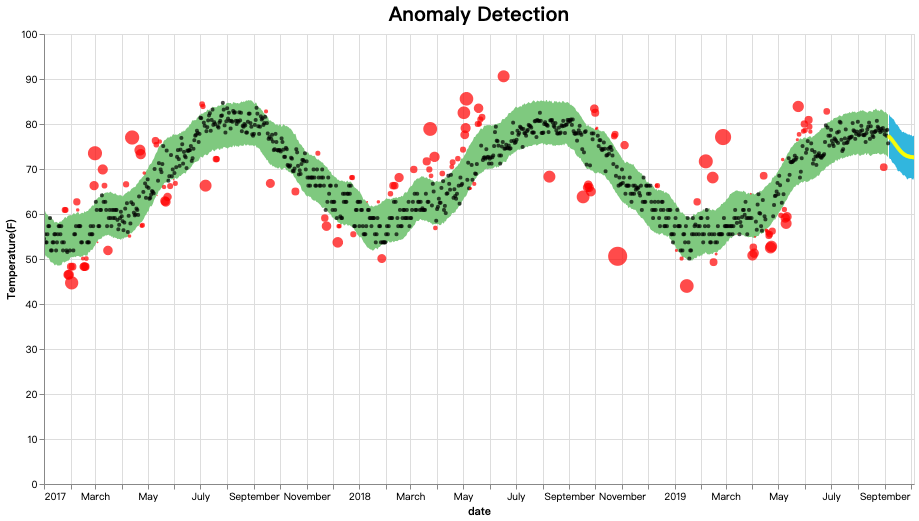

In [104]:
F.fit_forecast_model(forecast_num=30,freq='D').pipe(F.fore_detect_anomalies).pipe(F.fore_plot_anomalies)

## Applications3: Transformed original data into cleaning data by cleaning outliers

In [105]:
NF=Forecast_Model(data,interval_width = 0.8, changepoint_range = 0.8,\
                 period=20,daily_seasonality = False, yearly_seasonality = True,\
                    weekly_seasonality = False,seasonality_mode = 'multiplicative',if_forecast=False)

In [106]:
clear_data=NF.fit_forecast_model().pipe(NF.fore_detect_anomalies).pipe(NF.outlier_dealer)
clear_data.tail()

Training Time:  0:00:02.726124


,day,count
973,2019-09-01,77.7
974,2019-09-02,78.5
975,2019-09-03,77.4
976,2019-09-04,78.7
977,2019-09-05,75.7


## Visulaization of outlier-cleaning data

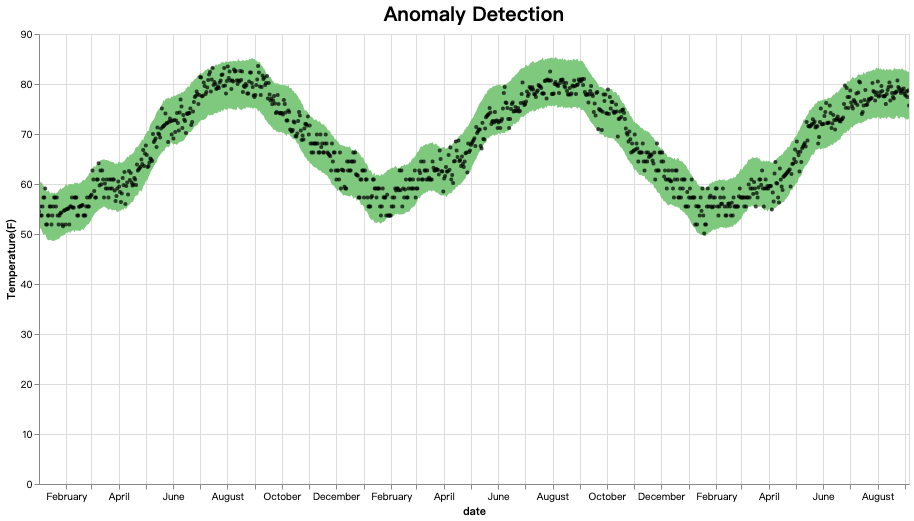

In [107]:
NF.duse.pipe(NF.fore_detect_anomalies).pipe(NF.fore_plot_anomalies)